In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
from itertools import combinations
from os.path import isfile
from enum import IntEnum

In [2]:
df = pd.read_csv('dane_projekt1.csv' if isfile('dane_projekt1.csv') else 'https://rentry.co/qoem84py/raw', sep=';')
df.head()

,id,waga,wzrost,plec,dzieci,wiek,dochod,oszczednosci,jednoos,miejsce,wydatki_zyw
0,52,78.93,176.20,2,5,59,979.01,673.17,0,3,194.96
1,101,78.66,165.73,1,3,52,1043.36,543.89,0,2,259.20
2,146,74.29,171.33,1,2,57,1227.69,773.20,0,1,244.41
3,281,79.11,169.24,1,1,59,2356.74,1914.74,1,2,239.77
4,167,79.23,177.78,2,1,48,1264.95,536.29,1,3,291.05


In [3]:
class Plec(IntEnum):
    Kobieta = 1
    Mezczyzna = 2
    
class Gospodarstwo(IntEnum):
    Wieloosobowe = 0
    Jednoosobowe = 1

class Miejsce(IntEnum):
    do10_000 = 1
    do100_000 = 2
    powyzej = 3
    
    def __str__(self):
        if self == Miejsce.do10_000:
            return 'do 10 000'
        elif self == Miejsce.do100_000:
            return 'do 100 000'
        else:
            return 'powyżej 100 000'


## Zadanie 1:
Wczytaj dane, obejrzyj je i podsumuj w dwóch-trzech zdaniach. Zadania pomocnicze:


- Ile jest obserwacji? Przedyskutuj strukturę zbioru danych: ile jest zmiennych ilościowych, a ile jakościowych? Czy występują braki danych? (1pkt)

In [4]:
print(f"Ilość obserwacji: {df.shape[0]}")
print(f"Zmienne ilościowe: {df[['waga', 'wzrost', 'dzieci', 'wiek', 'dochod', 'oszczednosci', 'wydatki_zyw']].shape[1]}")
print(f"Zmienne jakościowe: {df[['plec', 'jednoos', 'miejsce']].shape[1]}")
print(f"Ilość pustych wierszy: {df.isnull().any(axis=1).sum()}")

Ilość obserwacji: 310
Zmienne ilościowe: 7
Zmienne jakościowe: 3
Ilość pustych wierszy: 0


- Przedstaw i skomentuj zasadne tabele częstości lub statystykę opisową dla zmiennych w zbiorze danych
(zwróć uwagę na typ zmiennych). (1pkt)

In [5]:
df.describe()

,id,waga,wzrost,plec,dzieci,wiek,dochod,oszczednosci,jednoos,miejsce,wydatki_zyw
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,155.500000,79.814742,172.726774,1.458065,2.003226,56.241935,1519.658000,945.994839,0.429032,2.003226,12.383097
std,89.633513,3.292902,6.906733,0.499044,1.352209,6.746653,1293.464325,787.601212,0.495738,0.739537,3232.382607
min,1.000000,68.890000,155.670000,1.000000,0.000000,37.000000,645.270000,-204.240000,0.000000,1.000000,-55640.190000
25%,78.250000,77.430000,167.090000,1.000000,1.000000,52.000000,966.807500,392.545000,0.000000,1.000000,199.757500
50%,155.500000,79.890000,172.815000,1.000000,2.000000,56.000000,1190.840000,741.190000,0.000000,2.000000,249.265000
75%,232.750000,82.112500,178.032500,2.000000,3.000000,61.000000,1620.460000,1270.222500,1.000000,3.000000,283.267500
max,310.000000,86.730000,190.790000,2.000000,5.000000,77.000000,17412.240000,5485.220000,1.000000,3.000000,301.690000


Z powyższej statystyki wynika, że pojawiają się rekordy dla których wartość zmiennej `wydatki_zyw` są ujemne. Ponieważ wydatki nie mogą być ujemne, zdecydowano się na usunięcie tych rekordów.

In [6]:
print(f"Usunięto {df[df.wydatki_zyw < 0].shape[0]} obserwacji z ujemnymi wydatkami na żywność")
df = df[df.wydatki_zyw >= 0]

Usunięto 6 obserwacji z ujemnymi wydatkami na żywność


In [7]:
df.describe()

,id,waga,wzrost,plec,dzieci,wiek,dochod,oszczednosci,jednoos,miejsce,wydatki_zyw
count,304.00000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000
mean,152.50000,79.819309,172.805757,1.463816,1.990132,56.259868,1389.315724,887.975954,0.417763,2.000000,235.571151
std,87.90146,3.303614,6.935242,0.499511,1.341112,6.782444,660.781113,668.759849,0.494004,0.740172,57.232769
min,1.00000,68.890000,155.670000,1.000000,0.000000,37.000000,645.270000,-204.240000,0.000000,1.000000,56.270000
25%,76.75000,77.415000,167.130000,1.000000,1.000000,51.750000,965.830000,384.657500,0.000000,1.000000,204.207500
50%,152.50000,79.895000,172.890000,1.000000,2.000000,56.500000,1181.350000,722.325000,0.000000,2.000000,250.465000
75%,228.25000,82.142500,178.117500,2.000000,3.000000,61.000000,1613.947500,1236.880000,1.000000,3.000000,284.110000
max,304.00000,86.730000,190.790000,2.000000,5.000000,77.000000,4780.150000,3390.590000,1.000000,3.000000,301.690000


- Przedstaw i skomentuj (tam, gdzie zasadne) rozkłady zmiennych, w szczególności porównując je
wizualnie z rozkładem normalnym (np. z wykorzystaniem histogramów, wykresów kwantyl-kwantyl,
etc). (2pkt)

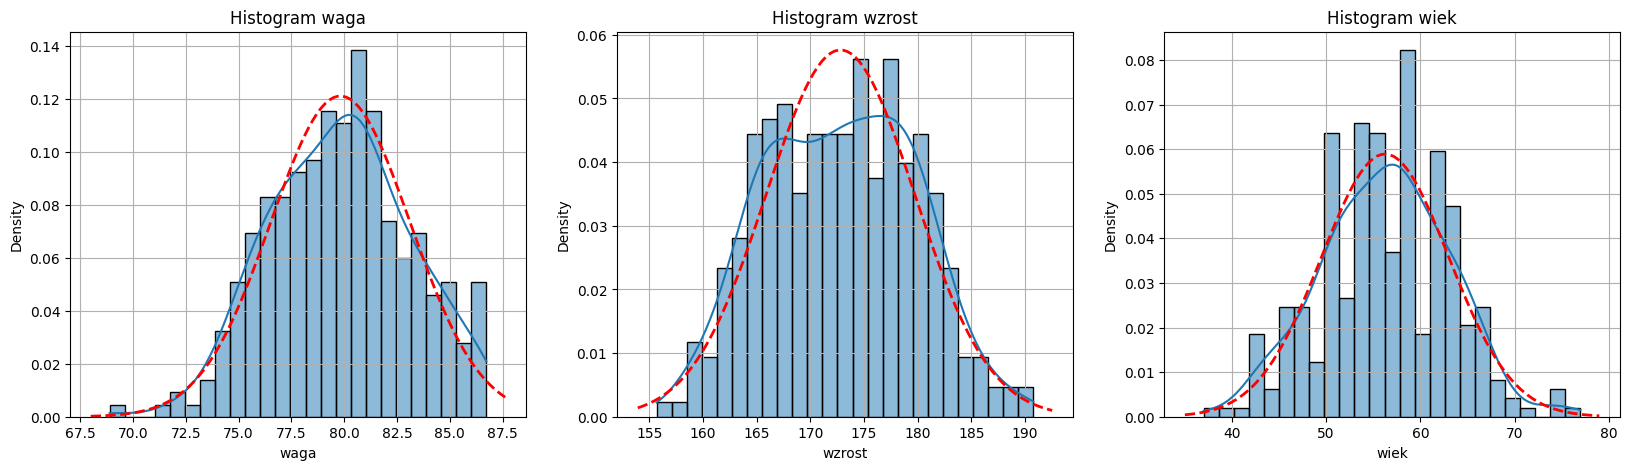

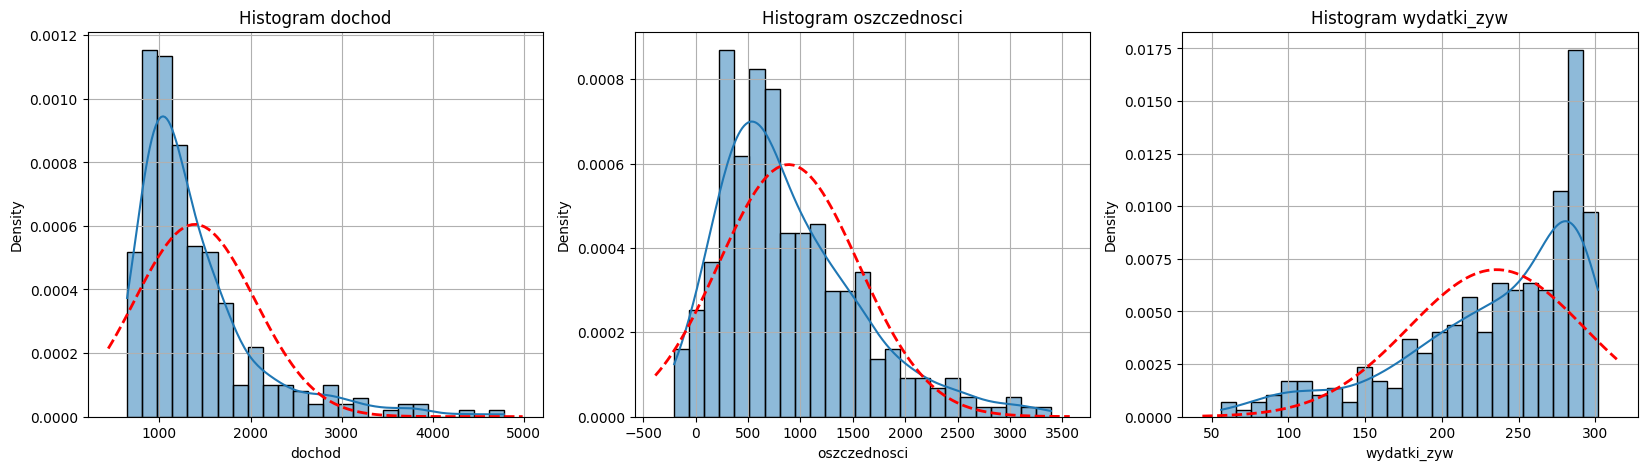

In [8]:
def make_hist(df, column, ax, bins=25):
    # Plot histogram
    sns.histplot(df[column], kde=True, ax=ax, bins=bins, stat='density')
    ax.set_title(f"Histogram {column}")
    ax.set_xlabel(column)
    # plot normal distribution
    mu, std = st.norm.fit(df[column])
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = st.norm.pdf(x, mu, std)
    ax.plot(x, p, 'r--', linewidth=2)
    ax.grid(True)
    

zmienne = ['waga', 'wzrost', 'wiek', 'dochod', 'oszczednosci', 'wydatki_zyw']

per_row = 3

for i in range(0, len(zmienne), per_row):
    fig, axs = plt.subplots(1, per_row, figsize=(20, 5))
    for j, zmienna in enumerate(zmienne[i:i+per_row]):
        make_hist(df, zmienna, axs[j])
    plt.show()

In [9]:
for col in ["waga", "wiek", "dochod", "oszczednosci", "wydatki_zyw", "wzrost"]:
    print(f"Skośność {col:<12}: {df[col].skew():.2f}")

Skośność waga        : -0.05
Skośność wiek        : -0.01
Skośność dochod      : 2.08
Skośność oszczednosci: 1.07
Skośność wydatki_zyw : -1.08
Skośność wzrost      : 0.03


Powyżej przedstawiono histogramy dla zmiennych ilościowych o ciągłym rozkładzie. Widać, że rozkłady zmiennych `waga` oraz `wiek` są zbliżone do rozkładu normalnego. Natomiast zmienne `dochod` oraz `oszczędności` mają rozkład prawoskośny. `wydatki_zyw` ma rozkład lewostronnie skośny. Rozkład zmiennej `wzrost` ciężko ocenić, jest on zbliżony do rozkładu normalnego, ale trochę także przypomina rozkład dwumodalny, zważywszy na płaskie maksimum.

## Zadanie 2: 
Sprawdź, czy występują pomiędzy zmiennymi zależności. Policz i zaprezentuj na wykresie typu
mapa ciepła (heatmap) zasadny współczynnik korelacji pomiędzy zmiennymi ilościowymi, a także zbadaj
zależność zmiennych jakościowych. Skomentuj wyniki ze szczególnym uwzględnieniem kwestii istotności
statystycznej. (3pkt)

In [10]:
#@markdown definicja funkcji print_corr

# Interpretacja współczynnika koncentracji Spearmana
# https://home.agh.edu.pl/~romanf/Wprowadzenie_do_MATLAB/_build/html/Analiza_istotnosci.html
corr_strength = {
    0.2: None,
    0.4: 'słaba',
    0.7: 'umiarkowana',
    0.9: 'silna',
    np.inf: 'bardzo silna'
}

corr_sign = {
    1: 'dodatnia',
    -1: 'ujemna'
}

"""
Funkcja print_corr(df) wypisuje zależności pomiędzy zmiennymi w DataFrame df.
"""
def print_corr(df):
    global corr_strength, corr_sign
    visited = set()
    any_corr = False
    for row in df.corr(method='spearman').iterrows():
        row_name, row = row
        for col in row.index:
            if row_name != col:
                if tuple(sorted([row_name, col])) in visited:
                    continue
                visited.add(tuple(sorted([row_name, col])))
                correlation = row[col]
                strength = None
                for strength in corr_strength:
                    if abs(correlation) < strength:
                        strength = corr_strength[strength]
                        break
                if strength is not None:
                    any_corr = True
                    print(f'{row_name} i {col}: {strength} zależność {corr_sign[np.sign(correlation)]}')
                    
    if not any_corr:
        print('Brak znaczących zależności liniowych między zmiennymi')

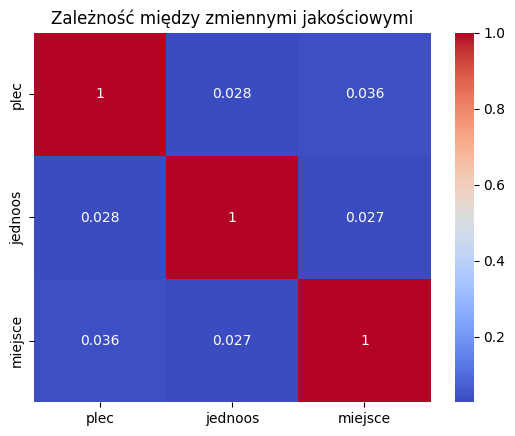

In [11]:
sns.heatmap(df[['plec', 'jednoos', 'miejsce']].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.title('Zależność między zmiennymi jakościowymi')
plt.show()

In [12]:
print_corr(df[['plec', 'jednoos', 'miejsce']])

Brak znaczących zależności liniowych między zmiennymi


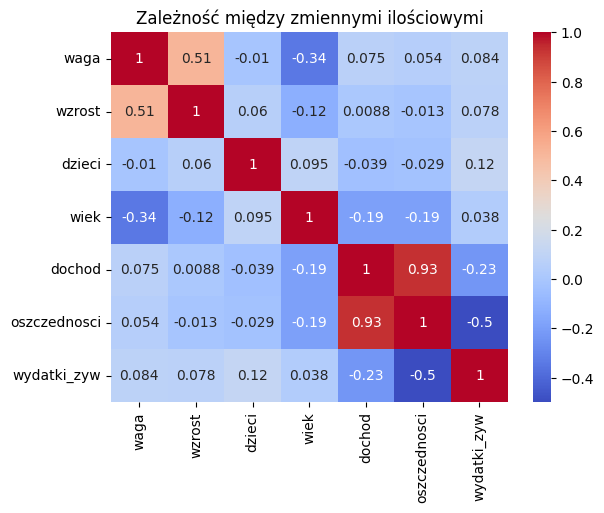

In [13]:
sns.heatmap(df[['waga', 'wzrost', 'dzieci', 'wiek', 'dochod', 'oszczednosci', 'wydatki_zyw']].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.title('Zależność między zmiennymi ilościowymi')
plt.show()

In [14]:
print_corr(df[['waga', 'wzrost', 'dzieci', 'wiek', 'dochod', 'oszczednosci', 'wydatki_zyw']])

waga i wzrost: umiarkowana zależność dodatnia
waga i wiek: słaba zależność ujemna
dochod i oszczednosci: bardzo silna zależność dodatnia
dochod i wydatki_zyw: słaba zależność ujemna
oszczednosci i wydatki_zyw: umiarkowana zależność ujemna


## Zadanie 3:

Podsumuj dane przynajmniej trzema różnymi wykresami (skomentuj każdy z wykresów). Podstawowy zestaw wykresów zawiera:

- Wykresy rozrzutu (scatter-plot) dla wszystkich zmiennych ilościowych względem zmiennej wydatki_zyw.
- Wykresy typu pudełkowy (boxplot) dla jednej wybranej zmiennej ilościowej w podziale na miejsce
zamieszkania respondentów.
- Wykres słupkowy skumulowany (stacked bar chart) dla płci respondenta i faktu, czy prowadzi jednoosobowe gospodarstwo domowe.

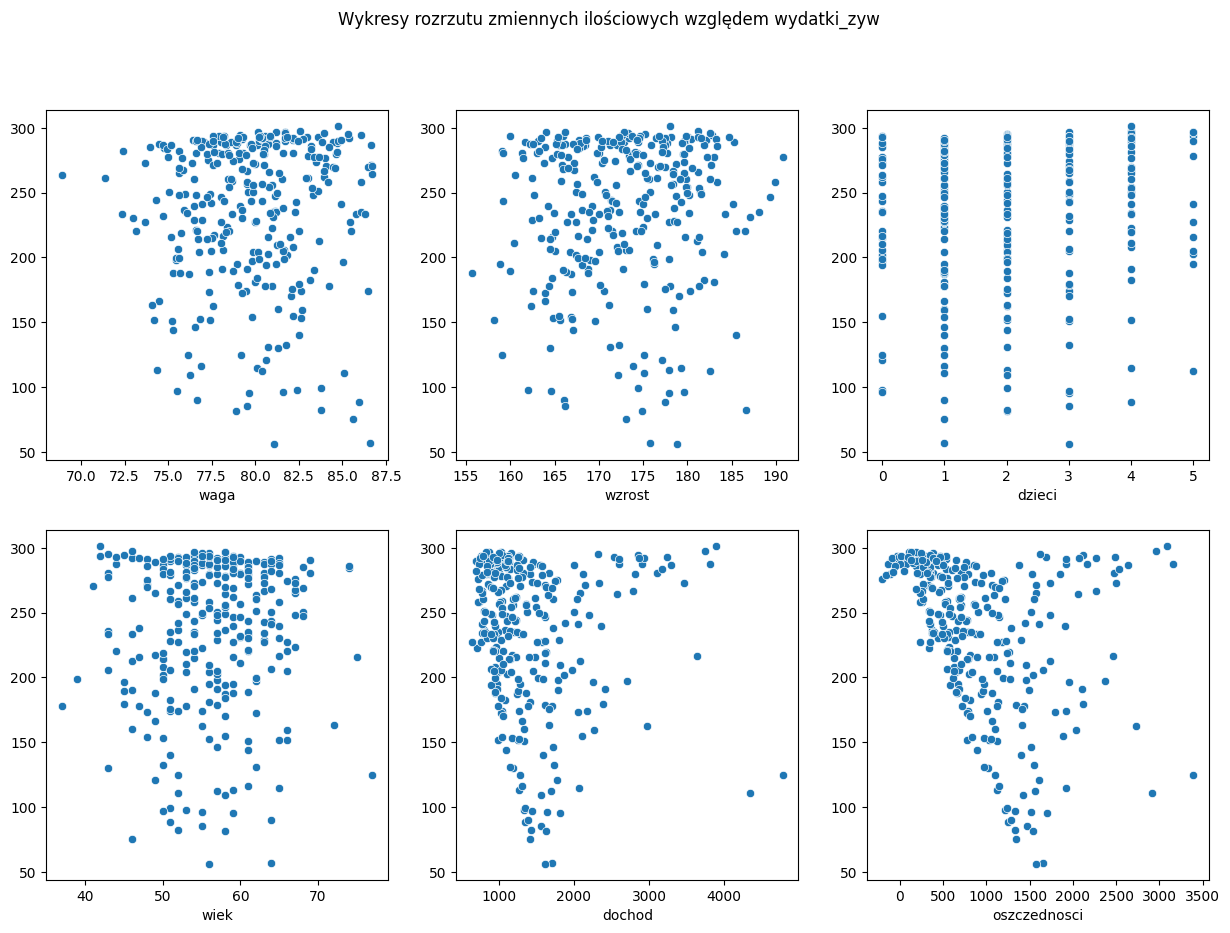

In [15]:
cols = ['waga', 'wzrost', 'dzieci', 'wiek', 'dochod', 'oszczednosci']
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(cols):
    sns.scatterplot(x=col, y='wydatki_zyw', data=df, ax=axs[i//3][i%3])
    axs[i//3][i%3].set(xlabel=col, ylabel='')
fig.suptitle('Wykresy rozrzutu zmiennych ilościowych względem wydatki_zyw')
plt.show()

Z wykresu widać negatywną zależność pomiędzy zmiennymi `dochod` oraz `wydatki_zyw` oraz pomiedzy `oszczędności` oraz `wydatki_zyw`. Z wykresu widać również dyskretny rozkład zmiennej `dzieci` oraz brak korelacji między `wiek` a `wydatki_zyw`.

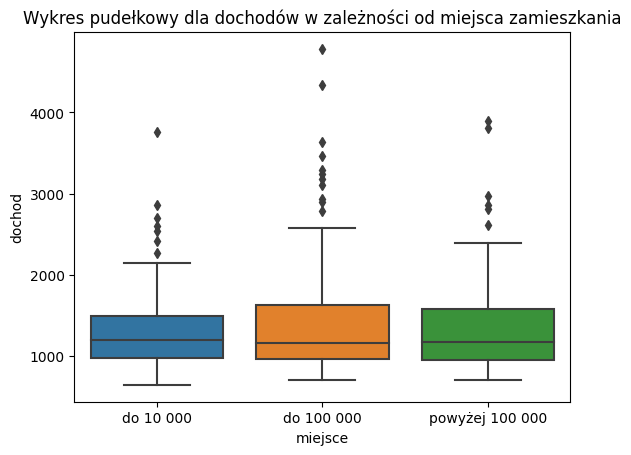

In [16]:

miejsca_str = [str(m) for m in Miejsce.__members__.values()]

sns.boxplot(x='miejsce', y='dochod', data=df)
plt.title('Wykres pudełkowy dla dochodów w zależności od miejsca zamieszkania')
plt.xticks(range(len(miejsca_str)), miejsca_str)

plt.show()

Z wykresu widać, że najbardziej zróżnicowane wydatki mają osoby zamieszkujące w średnich miastach. Widać również, że średnia wydatków pomiędzy miejscami zamieszkania jest zbliżona.

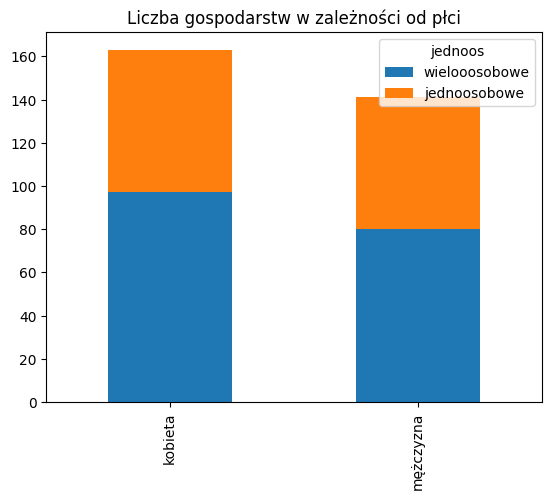

In [17]:
df.groupby(['plec', 'jednoos']).size().unstack().rename(
    columns={Gospodarstwo.Wieloosobowe: 'wielooosobowe', Gospodarstwo.Jednoosobowe: 'jednoosobowe'},
    index={Plec.Kobieta: 'kobieta', Plec.Mezczyzna: 'mężczyzna'}
).plot(kind='bar', stacked=True)
plt.xlabel('')
plt.title('Liczba gospodarstw w zależności od płci')
plt.show()

Widać, że największą grupę ankietowanych stanowią kobiety, które prowadzą wieloosobowe gospodarstwo domowe.

## Zadanie 4:

Policz dwustronne przedziały ufności na poziomie ufności 1 − α = 0.99 dla zmiennej wiek dla
następujących parametrów rozkładu:
- średnia i odchylenie standardowe;
- kwartyle 1, 2 i 3.

In [18]:
fmt = lambda x: f"({x[0]:.4f}, {x[1]:.4f})"

In [19]:
conf_level = 0.99
dof = df.shape[0] - 1

print(f"Przedział ufności dla średniej wieku: {fmt(st.t.interval(conf_level, dof, loc=df.wiek.mean(), scale=st.sem(df.wiek)))}")

ci_low = np.sqrt(dof * df.wiek.std() ** 2 / st.chi2.ppf(conf_level / 2, dof))
ci_high = np.sqrt(dof * df.wiek.std() ** 2 / st.chi2.ppf(conf_level / 2, dof))

print(f"Przedział ufności dla odchylenia standardowego wieku: {fmt((ci_low, ci_high))}") 

Przedział ufności dla średniej wieku: (55.2515, 57.2682)
Przedział ufności dla odchylenia standardowego wieku: (6.7934, 6.7934)


In [20]:
# przedział ufności dla kwantyli wieku
for k in range(1, 4):
    q = df.wiek.quantile(k/4)
    p = k/4
    print(f"Przedział ufności dla {k}. kwantyla wieku: {fmt(st.quantile_test(df.wiek, q=q, p=p).confidence_interval(conf_level))}")


Przedział ufności dla 1. kwantyla wieku: (50.0000, 53.0000)
Przedział ufności dla 2. kwantyla wieku: (55.0000, 58.0000)
Przedział ufności dla 3. kwantyla wieku: (59.0000, 62.0000)


## Zadanie 5:

Socjologowie bajtoccy dzielą społeczeństwo Bajtocji według czterech klas zamożności:
- klasa niższa (osiągany dochód poniżej 25 centylu rozkładu dochodów)
- klasa średnia (osiągany dochód równy lub wyższy 25 centylowi i niższy niż 75 centyl rozkładu dochodów)
- klasa wyższa średnia (osiągany dochód równy lub wyższy 75 centylowi i niższy niż 90 centyl rozkładu
dochodów)
- klasa wyższa (osiągany dochód równy lub wyższy 90 centylowi rozkładu dochodów)

Przedyskutuj i porównaj zróżnicowanie wydatków na żywność w wyżej wymienionych klasach zamożności
(2pkt: 0,5pkt za przeprowadzenie podziału, 1pkt za obliczenie właściwej miary zróżnicowania, 0,5pkt. za
komentarz i dyskusję wyników).

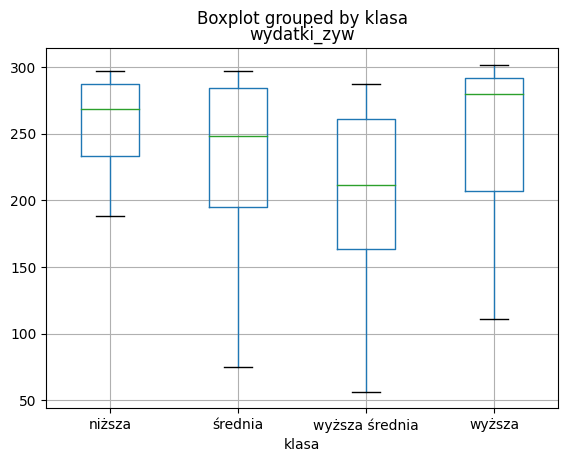

In [21]:
stratums = {
    df.dochod.quantile(.25): 0,
    df.dochod.quantile(.75): 1,
    df.dochod.quantile(.90): 2,
    np.inf: 3
}

stratums_labels = {
    0: 'niższa',
    1: 'średnia',
    2: 'wyższa średnia',
    3: 'wyższa'
}

df.assign(
    klasa=df.dochod.apply(lambda x: stratums[next(stratum for stratum in stratums if stratum >= x)])
).boxplot('wydatki_zyw', by='klasa')
plt.xticks([1, 2, 3, 4], [stratums_labels[i] for i in range(4)])
plt.show()

Z wykresu można wyczytać, że klasa średnia i wyższa średnia mają porównywalnie większe zróżnicowanie wydatków na żywność niż klasy niższa i wyższa. Widać także, że klasa wyższa średnia ma najmniejszą średnią wydatków na żywność.

## Zadanie 6:
Odpowiedz na następujące pytania badawcze, przeprowadzając najlepiej nadające się do tego
testy statystyczne na poziomie istotności α = 0,01:

- Czy kobiety cechują się wyższymi wartościami oszczędności niż mężczyzni?
- Czy niższa proporcja wydatków na żywność względem dochodu jest skorelowana z wyższymi oszczędnościami?
- Czy średnia waga kobiet w próbie jest wyższa niż 56 kg?

oraz:

- zweryfikuj dodatkową (sensowną) hipotezę o zgodności z konkretnym rozkładem parametrycznym dla
wybranej zmiennej (np. "zmienna A ma rozkład Poissona z parametrem 1").

Podaj wykorzystywane założenia i skomentuj czy wydają Ci się one uprawnione. Każdy test statystyczny po
1 punkcie (w sumie 4pkt). Punktowane jest sformułowanie hipotezy zerowej oraz alternatywnej (0,25pkt),
uzasadnienie/zasadność wybranego testu (0,25pkt), przeprowadzenie testu (0,25pkt) i podanie konkluzji
testu (0,25pkt).

W tym przykładzie sprawdzamy, czy oszczędności kobiet są większe od oszczędności mężczyzn.

Jako H0 przyjmujemy, że oszczędności kobiet są mniejsze lub równe oszczędnościom mężczyzn.
Jako H1 przyjmujemy, że oszczędności kobiet są większe od oszczędności mężczyzn.

Używamy ttest_ind, ponieważ jest to test który sprawdza czy dwie próbki mają identyczne wartości oczekiwane, a jako alternatywę mogą przyjąć 'greater' co oznacza, że sprawdzamy czy wartość oczekiwana pierwszej próbki jest większa od wartości oczekiwanej drugiej próbki.


In [22]:
alpha = 0.01

oszcz_kobiety = df[df.plec == Plec.Kobieta].oszczednosci
oszcz_mezczyzni = df[df.plec == Plec.Mezczyzna].oszczednosci

t_stat, p_val = st.ttest_ind(oszcz_kobiety, oszcz_mezczyzni, alternative='greater')

if p_val < alpha:
    print(f"Oszczędności kobiet są większe od oszczędności mężczyzn")
else:
    print(f"Nie ma podstaw do odrzucenia hipotezy zerowej (tego samego poziomu oszczędności)")

Nie ma podstaw do odrzucenia hipotezy zerowej (tego samego poziomu oszczędności)


W tym zadaniu sprawdzamy, czy poziom oszczędności zależy od wydatków na żywność. 

Jako H0 przyjmujemy, że poziom oszczędności nie zależy od wydatków na żywność.

Używamy testu korelacji Pearsona, ponieważ sprawdza on liniową zależność między zmiennymi. P-wartość określa prawdopodobieństwo, że w przypadku braku zależności liniowej, otrzymalibyśmy takie same dane jak w przypadku zależności liniowej.
Wartość `corr` określa czy zmienne są wprost proporcjonalne (dodatnia) czy odwrotnie proporcjonalne (ujemna).

In [23]:
alpha = 0.01

corr, p_val = st.pearsonr(df.wydatki_zyw, df.oszczednosci)

if p_val < alpha:
    if corr > 0:
        print(f"Poziom oszczędności rośnie wraz z wydatkami na żywność: {corr=}")
    elif corr < 0:
        print(f"Poziom oszczędności maleje wraz z wydatkami na żywność: {corr=}")
else:
    print(f"Nie ma podstaw do odrzucenia hipotezy zerowej")  
        


Poziom oszczędności maleje wraz z wydatkami na żywność: corr=-0.38290890825416546


Weryfikacja hipotezy, że średnia waga kobiet jest większa od 56 kg

H0: średnia waga kobiet jest mniejsza bądź równa 56 kg
H1: średnia waga kobiet jest większa od 56 kg

Używamy testu jednostronnego, ponieważ interesuje nas tylko to, czy średnia waga kobiet jest większa od 56 kg


In [24]:
alpha = 0.01

wagi = df.waga[df.plec == Plec.Kobieta]

t_stat, p_val = st.ttest_1samp(wagi, 56, alternative='greater')

if p_val < alpha:
    print(f"Średnia waga kobiet jest wyższa od 56 kg {p_val=}")
else:
    print(f"Nie ma podstaw do odrzucenia hipotezy zerowej (średnia waga kobiet jest mniejsza bądź równa 56 kg)")

Średnia waga kobiet jest wyższa od 56 kg p_val=1.5711163348632539e-152


Weryfikacja hipotezy, że dzieci mają rozkład Poissona. Parametr rozkładu oszacowujemy oczywiście jako średnią z danych. 

In [25]:
alpha = 0.01

dzieci = df.dzieci

mean = dzieci.mean()

t_stat, p_val = st.kstest(dzieci, 'poisson', args=(mean,))

if p_val < alpha:
    print(f"Dzieci mają rozkład Poissona ({p_val=})")
else:
    print(f"Nie ma podstaw do odrzucenia hipotezy zerowej (dzieci nie mają rozkładu Poissona)")

Dzieci mają rozkład Poissona (p_val=3.8543299749781077e-22)


## Zadanie 7:

Przeprowadź badanie wysokości wydatków na żywność z wykorzystaniem zmiennych z bazy.
Przyjmij poziom istotności α = 0.01. W tym celu:
- Oszacuj wstępny model zawierający wszystkie zmienne z oryginalnej bazy (poza id) oraz stałą, gdzie
zmienna wydatki_zyw jest zmienną objaśnianą. Pamiętaj o rozkodowaniu zmiennych jakościowych.
(0,5pkt)
- Skomentuj R2
, testy łącznej i indywidualnej istotności we wstępnym modelu. (1pkt)
- Sprawdź, czy wstępny model spełnia założenia Klasycznego Modelu Regresji Liniowej (KMRL). Zwróć
szczególną uwagę na kwestie liniowości formy funkcyjnej, homoskedastyczności i braku autokorelacji
składnika losowego oraz rozkładu składnika losowego. (2pkt)
- Sprawdź, czy we wstępnym modelu występuje problem niedokładnej współliniowości (multicollinearity )
(0,5pkt)
- Korzystając z analizy obserwacji odstających dla wstępnego modelu, sprawdź, czy baza zawiera błędy.

Jeśli znajdziesz podejrzane obserwacje, zdecyduj i uzasadnij, co z nimi zrobisz. (1pkt)
- Popraw model tak, aby spełniał jak najwięcej założeń KMRL. Opisz kroki podjęte do otrzymania
“najlepszego” modelu (4pkt).
Wskazówka: Rozważ różne formy funkcyjne oraz transformacje zmiennych.
- Przedstaw ilościową interpretację wybranych dwóch indywidualnie istotnych współczynników w “najlepszym” modelu. Pamiętaj, że stałej nie interpretuje się. Zalecany wybór zmiennych niepoddanych
transformacji. (1pkt)
- Jakie są opisowe charakterystyki osób, które cechują wydatki na żywność należące do górnych 10%
predykcji wydatków na żywność w Państwa “najlepszym” modelu? Sprawdź i przedyskutuj

In [26]:
alpha = 0.01
split = 0.95

# podział na zbiór treningowy i testowy oraz rozkopojowanie zmiennych jakościowych na one-hot encoding
df_onehot = pd.get_dummies(df, columns=['plec', 'jednoos', 'miejsce'])
# unikanie pułapki dummy variable trap
df_onehot = df_onehot.drop(columns=['plec_1', 'jednoos_0', 'miejsce_1'])
df_onehot = df_onehot.drop(columns=['id'])
train = df_onehot.sample(frac=split, random_state=2137)
test = df_onehot.drop(train.index)

In [27]:
#@markdown funkcje diagnozujące model

from statsmodels.stats.outliers_influence import variance_inflation_factor

def model_r2(model):
    # Korzystamy z rsquared_adj, ponieważ zwykłe rsquared zawsze będzie rosło wraz z dodawaniem nowych zmiennych
    print(f"{model.rsquared_adj*100:.2f}% zmienności zmiennej wydatki_zyw jest wyjaśniane przez zmienne objaśniające.", end=' ')
    if model.rsquared_adj > 0.9:
        print("Model dobrze wyjaśnia zmienność zmiennej wydatki_zyw.")
    elif model.rsquared_adj > 0.7:
        print("Model w miarę wyjaśnia zmienność zmiennej wydatki_zyw.")
    elif model.rsquared_adj > 0.5:
        print("Model słabo wyjaśnia zmienność zmiennej wydatki_zyw.")
    else:
        print("Model bardzo słabo wyjaśnia zmienność zmiennej wydatki_zyw.")
        
        
def model_test(model, norm = lambda x: x):
    loss = norm(model.predict(sm.add_constant(test.drop(columns=['wydatki_zyw'])))) - test.wydatki_zyw
    loss = np.abs(loss)
    print(f"Średni błąd modelu przy testowaniu wynosi {loss.mean():.2f}")
    
    
    plt.plot(test.index, test.wydatki_zyw, label='Actual')
    plt.plot(test.index, norm(model.predict(sm.add_constant(test.drop(columns=['wydatki_zyw'])))), label='Predicted')
    plt.legend()
    plt.title(f'Actual vs model test predictions')
    
def model_vif(model):
    vif = pd.DataFrame()
    vif["Variable"] = model.model.exog_names
    vif["VIF"] = [variance_inflation_factor(model.model.exog, i) for i in range(len(model.model.exog_names))]
    return vif
    
def model_pvalues(model, a=alpha):
    p_values = pd.DataFrame(model.pvalues, columns=['p-value'])
    p_values.index = model.model.exog_names
    p_values['Significance'] = ['significant' if p < a else 'not significant' for p in p_values['p-value']]
    return p_values

def model_significance(model):
    print(f"Model jest {'znaczący' if model.f_pvalue < alpha else 'nieznaczący'} (p-value: {model.f_pvalue})")
    
def model_residuals(model, X):
    sns.regplot(x=model.predict(X), y=model.resid, lowess=True, line_kws={'color': 'red', 'lw': 1})
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted')
    
def model_errors(model):
    sm.graphics.influence_plot(model, criterion="cooks")

In [28]:
# Oszacuj wstępny model zawierający wszystkie zmienne z oryginalnej bazy (poza id) oraz stałą, gdzie zmienna wydatki_zyw jest zmienną objaśnianą.
X = sm.add_constant(train.drop(columns=['wydatki_zyw']))
y = train.wydatki_zyw

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            wydatki_zyw   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     58.66
Date:                Mon, 13 May 2024   Prob (F-statistic):           1.14e-62
Time:                        08:34:10   Log-Likelihood:                -1415.9
No. Observations:                 289   AIC:                             2854.
Df Residuals:                     278   BIC:                             2894.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          269.2759     93.077      2.893      0.004      86.050     452.502
waga            -0.8481      0.780     -1.087      0.278      -2.384       0.688
wzrost          -0.0894      0.419     -0.213      0.831      -0.914       0.735
dzieci           2.9661      1.471      2.017      0.045       0.071       5.861
wiek            -0.5343      0.316     -1.692      0.092      -1.156       0.087
dochod           0.1860      0.009     20.760      0.000       0.168       0.204
oszczednosci    -0.2141      0.010    -21.922      0.000      -0.233      -0.195
plec_2           7.4522      6.222      1.198      0.232      -4.795      19.699
jednoos_1        9.7316      6.185      1.574      0.117      -2.443      21.906
miejsce_2       -5.7899      4.827     -1.200      0.231     -15.292       3.712
miejsce_3        0.0342      5.378      0.006      0.995     -10.554      10.622
==============================================================================
Omnibus:                      197.324   Durbin-Watson:                   2.166
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2836.172
Skew:                          -2.559   Prob(JB):                         0.00
Kurtosis:                      17.468   Cond. No.                     8.87e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
model_r2(model)
model_significance(model)

66.69% zmienności zmiennej wydatki_zyw jest wyjaśniane przez zmienne objaśniające. Model słabo wyjaśnia zmienność zmiennej wydatki_zyw.
Model jest znaczący (p-value: 1.13925198929067e-62)


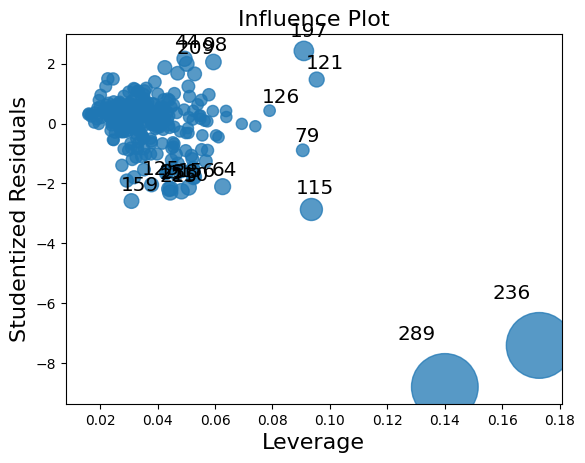

In [30]:
model_errors(model)

In [31]:
model_r2(model)
model_significance(model)

66.69% zmienności zmiennej wydatki_zyw jest wyjaśniane przez zmienne objaśniające. Model słabo wyjaśnia zmienność zmiennej wydatki_zyw.
Model jest znaczący (p-value: 1.13925198929067e-62)


In [32]:
model_pvalues(model)

,p-value,Significance
const,4.117254e-03,significant
waga,2.780363e-01,not significant
wzrost,8.311556e-01,not significant
dzieci,4.468768e-02,not significant
wiek,9.181943e-02,not significant
dochod,1.861971e-58,significant
oszczednosci,1.514147e-62,significant
plec_2,2.320110e-01,not significant
jednoos_1,1.167341e-01,not significant
miejsce_2,2.313353e-01,not significant


Średni błąd modelu przy testowaniu wynosi 27.05


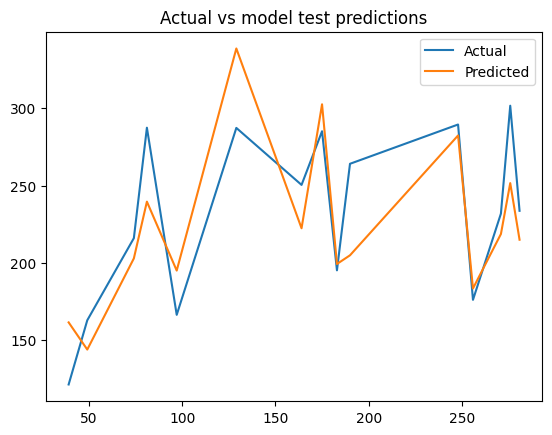

In [33]:
model_test(model)

In [34]:
model_vif(model)

,Variable,VIF
0,const,2284.695066
1,waga,1.696053
2,wzrost,2.199152
3,dzieci,1.028427
4,wiek,1.195118
5,dochod,8.720679
6,oszczednosci,10.572395
7,plec_2,2.538475
8,jednoos_1,2.430399
9,miejsce_2,1.526277


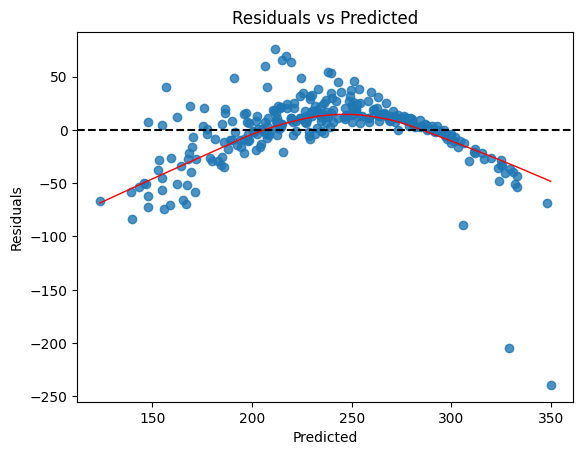

In [35]:
model_residuals(model, X)

Z wykresu reszt widać vs leverage widać 2 obserwacje odstające. Usunięto je z modelu dla poprawy jakości modelu.

In [36]:
train = train.drop([236, 289])

In [37]:
columns = train.columns.drop('wydatki_zyw')

formula = 'wydatki_zyw ~ ' + ' + '.join(columns)
formula += " + "
formula += " + ".join([f"np.power({col}, 2)" for col in columns])
formula += " + "
formula += " + ".join([f"{col1}*{col2}" for col1, col2 in combinations(columns, 2)])

model = smf.ols(formula=formula, data=train).fit()
sig = model_pvalues(model)
sig[sig.Significance == 'significant']

,p-value,Significance
dochod,7.311290e-94,significant
oszczednosci,2.150038e-103,significant
"np.power(dochod, 2)",2.947435e-291,significant
"np.power(oszczednosci, 2)",2.523255e-277,significant
dochod:oszczednosci,4.143161e-285,significant


Analizując wykres wartości resztowych można zaobserwować brak liniowości. Z analizy istotności wiemy, że najważnejsze są zmienne `dochod` oraz `oszczednosci`, dlatego spróbujemy przekształcić te zmienne.

In [38]:
train['dochod_pow2'] = train.dochod ** 2
train['oszczednosci_pow2'] = train.oszczednosci ** 2
train['dochod_oszczednosci'] = train.dochod * train.oszczednosci
test['dochod_pow2'] = test.dochod ** 2
test['oszczednosci_pow2'] = test.oszczednosci ** 2
test['dochod_oszczednosci'] = test.dochod * test.oszczednosci

X = sm.add_constant(train.drop(columns=['wydatki_zyw']))
y = train.wydatki_zyw

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            wydatki_zyw   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.045e+04
Date:                Mon, 13 May 2024   Prob (F-statistic):               0.00
Time:                        08:34:10   Log-Likelihood:                -422.51
No. Observations:                 287   AIC:                             873.0
Df Residuals:                     273   BIC:                             924.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.5474      3.180      0.172      0.863      -5.713       6.808
waga                    0.3492      0.026     13.572      0.000       0.299       0.400
wzrost                  0.0151      0.014      1.091      0.276      -0.012       0.042
dzieci                  1.5204      0.048     31.470      0.000       1.425       1.616
wiek                   -0.2474      0.010    -23.832      0.000      -0.268      -0.227
dochod                  0.7002      0.002    433.990      0.000       0.697       0.703
oszczednosci           -0.6997      0.001   -484.533      0.000      -0.702      -0.697
plec_2                 -0.1449      0.207     -0.700      0.484      -0.552       0.262
jednoos_1              -0.3622      0.255     -1.423      0.156      -0.863       0.139
miejsce_2               0.1358      0.158      0.859      0.391      -0.176       0.447
miejsce_3               0.1789      0.176      1.018      0.310      -0.167       0.525
dochod_pow2            -0.0004   1.27e-06   -353.052      0.000      -0.000      -0.000
oszczednosci_pow2      -0.0004   1.22e-06   -368.331      0.000      -0.000      -0.000
dochod_oszczednosci     0.0009   2.48e-06    362.298      0.000       0.001       0.001
==============================================================================
Omnibus:                        0.842   Durbin-Watson:                   2.183
Prob(Omnibus):                  0.656   Jarque-Bera (JB):                0.643
Skew:                           0.105   Prob(JB):                        0.725
Kurtosis:                       3.097   Cond. No.                     2.17e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
model_significance(model)

Model jest znaczący (p-value: 0.0)


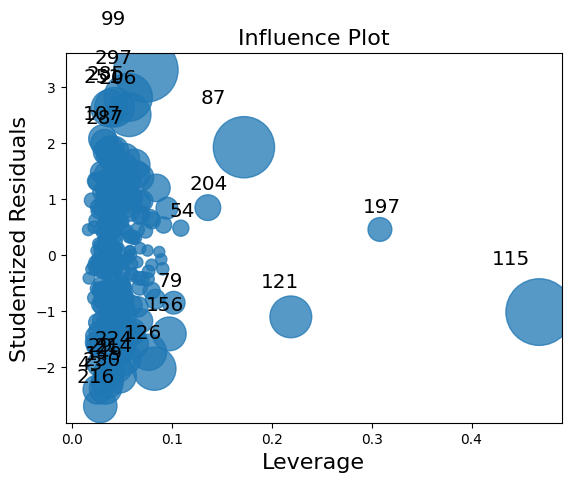

In [40]:
model_errors(model)

Średni błąd modelu przy testowaniu wynosi 0.92


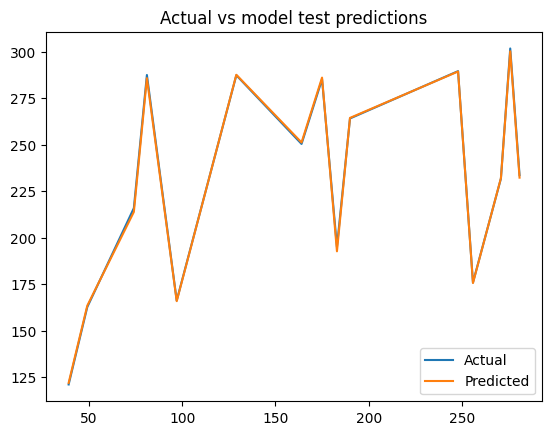

In [41]:
model_test(model)

In [42]:
model_pvalues(model)

,p-value,Significance
const,8.634605e-01,not significant
waga,2.049228e-32,significant
wzrost,2.761073e-01,not significant
dzieci,8.174867e-93,significant
wiek,1.181667e-68,significant
dochod,0.000000e+00,significant
oszczednosci,0.000000e+00,significant
plec_2,4.843410e-01,not significant
jednoos_1,1.559584e-01,not significant
miejsce_2,3.911987e-01,not significant


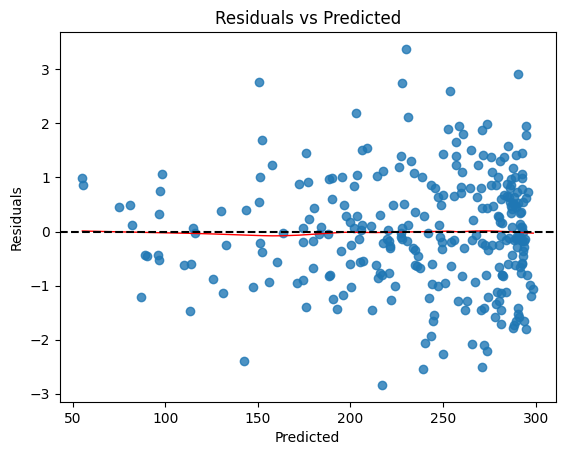

In [43]:
model_residuals(model, X)

Sprawdzanie założeń KMRL:

In [44]:
# check if expected value of residuals is 0

print(f"Średnia reszt modelu wynosi {model.resid.mean():.2f}")

Średnia reszt modelu wynosi 0.00


In [45]:
# check if regression model is homoscedastic

fval, pval, ordering = sm.stats.diagnostic.het_goldfeldquandt(model.resid, X)

if pval < alpha:
    print("Model nie jest homoscedastyczny")
else:
    print("Model jest homoscedastyczny")

Model jest homoscedastyczny


In [46]:
# check if covariance between residuals is zero
lm, lm_pvalue, fvalue, f_pvalue = sm.stats.diagnostic.het_breuschpagan(model.resid, X)

if f_pvalue < alpha:
    print("Wariancja reszt nie zależy od zmiennych objaśniających")
else:
    print("Wariancja reszt zależy od zmiennych objaśniających")
    

Wariancja reszt zależy od zmiennych objaśniających


In [47]:
# check if random component of model is normally distributed

jb, jbpv, skw, kurt = sm.stats.stattools.jarque_bera(model.resid)

if jbpv < alpha:
    print("Reszty modelu nie są rozkładem normalnym")
else:
    print("Reszty modelu są rozkładem normalnym")

Reszty modelu są rozkładem normalnym


Przedstaw ilościową interpretację wybranych dwóch indywidualnie istotnych współczynników w “najlepszym” modelu. Pamiętaj, że stałej nie interpretuje się. Zalecany wybór zmiennych niepoddanych

In [48]:
fmt = lambda x: ("wzrastają" if x > 0 else "maleją") + f" o {abs(x):.2f} zł"

print(f"Za każdy 1% wzrostu dochodów, wydatki na żywność {fmt(model.params['dochod'])}")
print(f"Za każdy 1% wzrostu dzieci, wydatki na żywność {fmt(model.params['dzieci'])}")

Za każdy 1% wzrostu dochodów, wydatki na żywność wzrastają o 0.70 zł
Za każdy 1% wzrostu dzieci, wydatki na żywność wzrastają o 1.52 zł


Jakie są opisowe charakterystyki osób, które cechują wydatki na żywność należące do górnych 10% predykcji wydatków na żywność w Państwa “najlepszym” modelu?

In [49]:
upper_decile = model.predict(sm.add_constant(train.drop(columns=['wydatki_zyw']))).quantile(0.9)

df[df.wydatki_zyw > upper_decile].describe()

,id,waga,wzrost,plec,dzieci,wiek,dochod,oszczednosci,jednoos,miejsce,wydatki_zyw
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,140.766667,81.275667,174.240667,1.633333,2.866667,53.066667,1535.883333,761.765667,0.300000,2.066667,294.076667
std,105.054233,2.282406,6.480367,0.490133,1.306043,6.039715,975.916648,984.462383,0.466092,0.784915,2.188081
min,4.000000,77.560000,159.970000,1.000000,0.000000,42.000000,753.680000,-95.950000,0.000000,1.000000,291.850000
25%,43.250000,80.187500,170.547500,1.000000,2.000000,48.000000,877.115000,117.420000,0.000000,1.250000,292.607500
50%,130.000000,80.845000,174.615000,2.000000,3.000000,55.000000,1072.450000,325.600000,0.000000,2.000000,293.530000
75%,253.750000,82.465000,179.430000,2.000000,4.000000,57.750000,2060.535000,1351.660000,1.000000,3.000000,295.067500
max,302.000000,86.060000,184.690000,2.000000,5.000000,65.000000,3893.040000,3086.410000,1.000000,3.000000,301.690000
